In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, mergeSublistsWithSharedItems, initDataset
from utils.load import getSamples, getTopofeature, extractWeights
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


Files already downloaded and verified
cuda


In [3]:

# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_normal_save/"
global_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
gmodelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
round_set.sort(reverse=True)
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

for dirpath, dirnames, filenames in os.walk(global_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        gmodelpth_set.append(os.path.join(dirpath, filename).replace("\\","/")) if "model" in filename else None

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))
print(len(gmodelpth_set))


modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 16
else:
    assert 0==1


rounds [36, 34, 32, 30, 28, 26, 24, 22] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640
16


In [15]:
now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")

corr_set = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums
weight_keys = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]

for idround, round_number in enumerate(round_set):
    # if idround >= 1:
    #     break
    r_modelpth_set = modelpth_dict[f'{r}_normal'][0:normal_nums] + modelpth_dict[f'{r}_attack'][0:attack_nums]
    global_model_pth = [gm for gm in gmodelpth_set if (int(re.findall(r'-?\d+', gm)[-1]) == round_number)][0]
    print(global_model_pth)
    r_corr = np.zeros((total_nums, total_nums, 1))

    fvlist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    
    g_gradient = getGradients(modelpth=global_model_pth, model=model, dataloader=Dataloader)

    for idx, modelp1 in enumerate(r_modelpth_set):
        model.load_state_dict(torch.load(modelp1))

        gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
     
    # print(gradientlist[0])
    # 定义权重键名列表
    global_grad = [g_gradient[key] for key in weight_keys]

    # 使用列表推导式创建 local_grad 和 global_grad 列表

    for id1, v in enumerate(gradientlist):
        local_grad = [v[key] for key in weight_keys]
        corrlist = []
        for id2, _ in enumerate(local_grad):
            lg = local_grad[id2].cpu().reshape((weightsize,-1))
            gg = global_grad[id2].cpu().reshape((weightsize,-1))

            l = linear_CKA(lg.T, gg.T)
            k = kernel_CKA(lg.T, gg.T)

            corrlist.append((l+k)/2)

        fvlist.append(np.array(corrlist))
        print(fvlist[-1])

    

    for id1, v1 in enumerate(fvlist):
        if id1 >= total_nums:
            break
        for id2, v2 in enumerate(fvlist):
            if id2 >= total_nums:
                break
            if id2 <= id1:
                continue
            

            r_corr[id1][id2] = np.linalg.norm(v1-v2)
    
    corr_set.append([round_number, r_corr])

print(len(corr_set))
print(corr_set[0][1].shape)
    

/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_36.pt
Files already downloaded and verified
[0.97118262 0.92624034 0.85009273 0.80675964 0.83283332 0.73029932
 0.83356618 0.915608   0.8943093  0.91156172 0.89147298 0.91887049
 0.94480503 0.89378709 0.90933787 0.91780178 0.92795834 0.93077521
 0.94831411]
[0.84808109 0.82786637 0.72648691 0.87700484 0.75683853 0.53689672
 0.79156611 0.8035203  0.77799892 0.85979648 0.74768687 0.89633028
 0.80328273 0.71721671 0.55966883 0.83645565 0.70018924 0.8446521
 0.84479012]
[0.97046792 0.93474683 0.92562358 0.92855901 0.83921609 0.69536536
 0.85957336 0.86455043 0.89390245 0.90710161 0.90462231 0.93810429
 0.9200666  0.84004285 0.8680476  0.93556493 0.85410192 0.92732515
 0.89076753]
[0.99095509 0.92403968 0.91989236 0.8666056  0.77801608 0.63822485
 0.85111563 0.90930493 0.86970304 0.94211207 0.89905664 0.88061594
 0.94342739

Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/

[0.96584553 0.93079836 0.8434981  0.83348013 0.8586054  0.6987572
 0.85886726 0.90672831 0.89282919 0.90409782 0.88199329 0.91134833
 0.94369451 0.87988337 0.90441993 0.90521646 0.92113948 0.92917289
 0.94665678]
[0.84098275 0.81008014 0.70379892 0.86522071 0.73106123 0.51441417
 0.78418643 0.80780032 0.80530281 0.86836227 0.75853966 0.90102829
 0.82191888 0.70099014 0.55624677 0.84494375 0.6941379  0.84051077
 0.8476131 ]
[0.97478704 0.93587038 0.9227984  0.93467252 0.83292244 0.68187332
 0.84683788 0.82945729 0.8926716  0.90134012 0.88762108 0.93154041
 0.92470049 0.82292374 0.85164321 0.92800168 0.83845913 0.9194348
 0.8789682 ]
[0.99226182 0.93523801 0.92931771 0.88148862 0.78953002 0.61709197
 0.85743277 0.90343019 0.85360622 0.93479463 0.87908733 0.86168653
 0.93850111 0.84381816 0.90656111 0.91464517 0.90067156 0.93583674
 0.9190428 ]
[0.89009232 0.73796347 0.73814524 0.70772014 0.7423517  0.732255
 0.75690717 0.92332699 0.86281028 0.89620222 0.93012761 0.90732176
 0.91268767 0.

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


[0.96902581 0.90121947 0.87233716 0.85143555 0.85196547 0.71406756
 0.86531433 0.88738098 0.91823867 0.92492479 0.91916047 0.92607902
 0.95478629 0.88026018 0.90965125 0.90500269 0.92933455 0.92642126
 0.94894221]
[0.84700732 0.75989969 0.72343815 0.85912346 0.7333376  0.56078885
 0.80826558 0.75618459 0.81814948 0.89135885 0.77743076 0.92175537
 0.82812181 0.70320319 0.57375481 0.8552107  0.73654881 0.84979455
 0.86193605]
[0.97332558 0.89229853 0.93376073 0.94055636 0.82503814 0.7061825
 0.85114702 0.81914866 0.91180959 0.92462291 0.92074253 0.95260878
 0.93910571 0.83950097 0.87798778 0.94954524 0.87808673 0.93235154
 0.90920148]
[0.99302545 0.92944183 0.95374086 0.89691002 0.76683249 0.62194341
 0.84188202 0.88431486 0.87686874 0.9459988  0.90353754 0.86934359
 0.94635026 0.83862651 0.9087086  0.92614874 0.91863213 0.93618994
 0.93505616]
[0.8845255  0.62586344 0.69672565 0.68689579 0.72560883 0.71911764
 0.72678151 0.88471452 0.83010932 0.87763327 0.90373226 0.88856254
 0.89390545

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


[0.98084854 0.88492802 0.91068933 0.86352048 0.92248503 0.77582815
 0.9051412  0.91402302 0.9273387  0.96485076 0.93990344 0.9504821
 0.95403748 0.91783579 0.88346908 0.94747583 0.91968897 0.95078947
 0.95238337]
[0.87872574 0.86639343 0.79402431 0.88731115 0.77185509 0.63275
 0.81847744 0.87708305 0.74607725 0.88519064 0.76139893 0.89465898
 0.8345656  0.81678368 0.67342618 0.8601002  0.83585117 0.88205673
 0.88941272]
[0.97221348 0.90345991 0.94795457 0.95343434 0.90617584 0.67673657
 0.88320473 0.88938276 0.88246224 0.90681878 0.93786353 0.95758339
 0.94049878 0.90927768 0.92486522 0.95123196 0.94579227 0.94877541
 0.95771874]
[0.98707504 0.93736682 0.9607367  0.92860598 0.86962753 0.68262151
 0.92996618 0.88490137 0.93001854 0.93811289 0.91917157 0.91672348
 0.94188801 0.88380043 0.89155371 0.94325342 0.9250853  0.95111011
 0.96015336]
[0.89185866 0.63598886 0.67473718 0.62841806 0.66252501 0.43041412
 0.70589219 0.79506263 0.5885401  0.69058961 0.69012975 0.74561913
 0.77792409 0.

Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


[0.9717036  0.94113098 0.93563871 0.90719692 0.93463732 0.8691931
 0.92932972 0.94693586 0.95916171 0.96654347 0.96416813 0.97279786
 0.97749823 0.95273442 0.93530891 0.9571006  0.95619911 0.96280328
 0.97062593]
[0.85456311 0.83175566 0.75536197 0.86254004 0.77227987 0.60181276
 0.8123274  0.82862353 0.7200976  0.85615091 0.71984637 0.86543217
 0.81068158 0.76391863 0.57973161 0.82217514 0.77315245 0.84156295
 0.86932499]
[0.9738256  0.93929991 0.94767629 0.95328772 0.88851043 0.71885302
 0.87356227 0.88783926 0.90508874 0.92017603 0.94076652 0.95682039
 0.94830655 0.91923377 0.91101604 0.94739456 0.93080685 0.93231035
 0.9482152 ]
[0.98805898 0.97216424 0.96768033 0.93420707 0.87901341 0.78010971
 0.93099448 0.93935518 0.96149662 0.96089273 0.96880065 0.94980024
 0.9765904  0.93197064 0.95477943 0.9653994  0.96262417 0.97121791
 0.97237361]
[0.88234137 0.66412703 0.69548615 0.65062375 0.65959118 0.47705717
 0.69830168 0.85184417 0.65437203 0.73902417 0.77974559 0.77514512
 0.83993199

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


[0.98156594 0.89856824 0.93761523 0.93606069 0.93287734 0.84149072
 0.92887292 0.94521043 0.95658788 0.9721101  0.96349627 0.96495762
 0.9707354  0.95708685 0.93329622 0.95845201 0.94981142 0.95974106
 0.96233788]
[0.88604844 0.84467076 0.78401775 0.83292612 0.79093268 0.65984674
 0.85200275 0.8672474  0.72402525 0.86804014 0.7318614  0.83213347
 0.80403381 0.81382316 0.63546106 0.83316455 0.79747006 0.86099692
 0.8809307 ]
[0.9781873  0.90142617 0.94862833 0.93541252 0.90411553 0.70181822
 0.88448013 0.89793565 0.90485344 0.91608794 0.93874296 0.9401286
 0.94408996 0.94378723 0.92697643 0.95066075 0.9465003  0.94456799
 0.96657818]
[0.98359073 0.94825371 0.96285146 0.94147153 0.89910388 0.78129547
 0.9269333  0.9371734  0.95939413 0.95783952 0.95037925 0.94767112
 0.96033137 0.93542478 0.9384154  0.96095421 0.9581206  0.96642947
 0.97653614]
[0.89861631 0.6119626  0.63841692 0.60823011 0.64280737 0.44172031
 0.6811658  0.84584239 0.60858203 0.71051212 0.71468272 0.69457929
 0.78190233

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


[0.9860708  0.9540482  0.9652052  0.94554806 0.9345487  0.86317254
 0.94711123 0.95740506 0.96632222 0.97869017 0.96997599 0.96462596
 0.97720428 0.96505312 0.94900616 0.96699943 0.96517422 0.97055675
 0.9750599 ]
[0.8861682  0.80830807 0.79049677 0.82704592 0.78983745 0.64105342
 0.83606938 0.89035446 0.72260602 0.88091813 0.73838965 0.83549674
 0.8111563  0.80049101 0.6146297  0.80788831 0.77615791 0.83021388
 0.8666486 ]
[0.97777136 0.92236263 0.94442519 0.93437013 0.89750191 0.7164802
 0.87486825 0.90007478 0.90243566 0.90984872 0.93451336 0.93807479
 0.95077184 0.93443886 0.91181237 0.9384252  0.93274909 0.92057464
 0.95520437]
[0.9891472  0.97006673 0.95009434 0.93955788 0.90473089 0.8076174
 0.94898323 0.93843699 0.96413455 0.95828234 0.95313848 0.94702498
 0.97099507 0.9480373  0.95181531 0.96769353 0.96685725 0.97345908
 0.98244039]
[0.90356194 0.6549253  0.69209293 0.59748716 0.61759703 0.41115987
 0.67220808 0.85749163 0.61326086 0.71795374 0.71771377 0.69101015
 0.80438891 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


[0.98345303 0.93486746 0.96237899 0.92436296 0.93223354 0.87451524
 0.94276883 0.95603893 0.97023646 0.97828154 0.97554054 0.963521
 0.98227716 0.95968261 0.94578703 0.96389738 0.96218517 0.96420193
 0.96822868]
[0.91260463 0.85600066 0.82138768 0.80671264 0.80148686 0.66534548
 0.8173246  0.88499798 0.73195984 0.87820446 0.74295353 0.82711188
 0.80793021 0.79070112 0.58894201 0.79905943 0.75737131 0.81751119
 0.86049284]
[0.96509684 0.92672029 0.9345956  0.91257909 0.89779778 0.75213546
 0.87450321 0.8892172  0.91101071 0.90897545 0.93577695 0.93405319
 0.95423038 0.93190476 0.9076921  0.9427707  0.93181541 0.91921795
 0.96010392]
[0.96830923 0.96069554 0.95008566 0.94420192 0.92551484 0.86875656
 0.9576151  0.95288244 0.96746258 0.9623662  0.96027851 0.95252802
 0.98009325 0.95534402 0.96247575 0.97551175 0.97685818 0.98052807
 0.98449607]
[0.90700745 0.66978986 0.65375853 0.57014215 0.61439393 0.45514481
 0.67733734 0.89212129 0.6356037  0.72154299 0.74928751 0.69080714
 0.82777425 

In [16]:
np.savetxt("./corrset_temp.txt",np.array([row[1] for row in corr_set]).reshape(len(corr_set), -1))

# PCODE

In [17]:
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps

36 (36, 36)


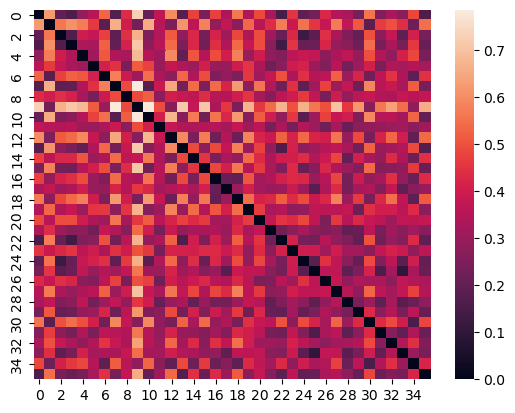

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


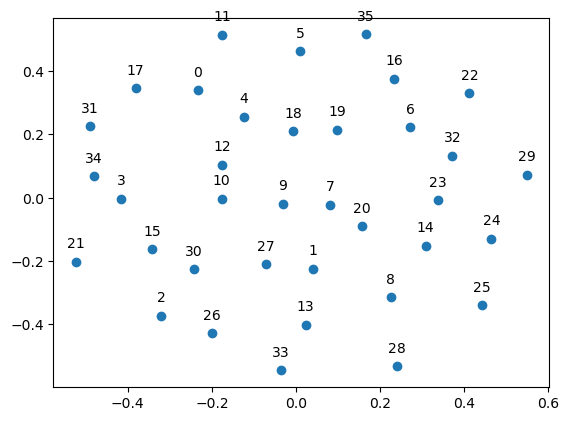

d 0 0 0.0 inf []
d 0 1 0.0 0.5452659634019796 [[9, 17]]
d 0 2 0.0 0.5432640781811056 [[9, 28]]
d 0 3 0.0 0.5076350098194118 [[9, 11]]
d 0 4 0.0 0.5042795692448372 [[9, 26]]
d 0 5 0.0 0.4977659574733485 [[9, 23]]
d 0 6 0.0 0.4858270658013556 [[5, 9]]
d 0 7 0.0 0.48144045211629594 [[8, 10]]
d 0 8 0.0 0.47185319296580397 [[10, 34]]
d 0 9 0.0 0.45856033845770805 [[9, 21]]
d 0 10 0.0 0.45698673767668274 [[9, 33]]
d 0 11 0.0 0.4463693861957527 [[10, 16]]
d 0 12 0.0 0.4440674025723982 [[7, 20]]
d 0 13 0.0 0.4407500449925661 [[9, 25]]
d 0 14 0.0 0.4356946309606079 [[9, 31]]
d 0 15 0.0 0.43281813385522605 [[10, 14]]
d 0 16 0.0 0.4258456070405354 [[6, 7]]
d 0 17 0.0 0.4090859342396337 [[10, 30]]
d 0 18 0.0 0.3824800955176133 [[9, 29]]
d 0 19 0.0 0.3779385077844808 [[10, 18]]
d 0 20 0.0 0.3634553017618315 [[9, 32]]
d 0 21 0.0 0.34312789491973616 [[9, 35]]
d 0 22 0.0 0.34036878780522406 [[1, 7]]
d 0 23 0.0 0.33635780152591355 [[9, 24]]
d 0 24 0.0 0.33314528730908877 [[2, 9]]
d 0 25 0.0 0.330155911

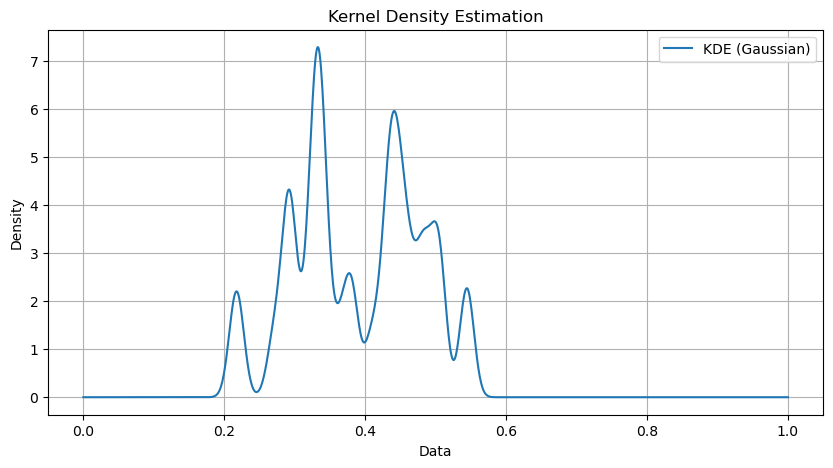

34 (36, 36)


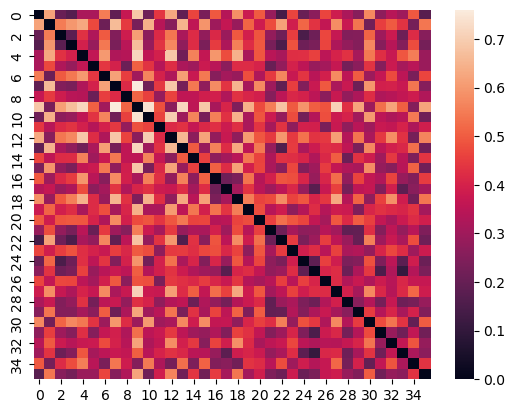

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


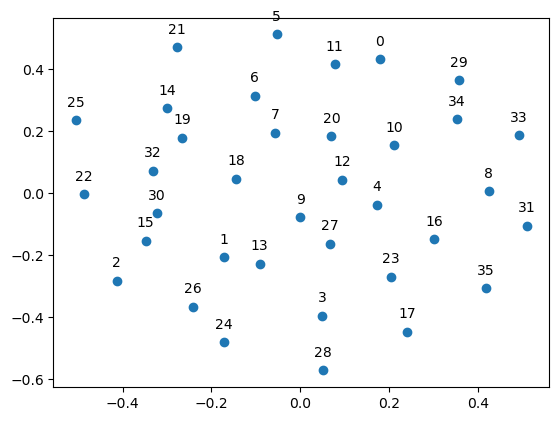

d 0 0 0.0 inf []
d 0 1 0.0 0.5668872132050651 [[4, 28]]
d 0 2 0.0 0.5234236308793373 [[4, 17]]
d 0 3 0.0 0.5185085044489565 [[9, 11]]
d 0 4 0.0 0.5061257921174676 [[7, 26]]
d 0 5 0.0 0.501546079479015 [[9, 23]]
d 0 6 0.0 0.4972433274002128 [[9, 33]]
d 0 7 0.0 0.49665000081082467 [[9, 25]]
d 0 8 0.0 0.49234510065500225 [[5, 9]]
d 0 9 0.0 0.4864451319630573 [[8, 9]]
d 0 10 0.0 0.4711487425640942 [[9, 31]]
d 0 11 0.0 0.446877170359695 [[9, 21]]
d 0 12 0.0 0.4452732730853364 [[4, 34]]
d 0 13 0.0 0.43814046095678927 [[10, 14]]
d 0 14 0.0 0.4240850194826995 [[7, 20]]
d 0 15 0.0 0.4065275720567826 [[9, 24]]
d 0 16 0.0 0.4046385251802438 [[4, 16]]
d 0 17 0.0 0.39890425516025274 [[10, 30]]
d 0 18 0.0 0.38881529863920217 [[2, 9]]
d 0 19 0.0 0.382986172382454 [[6, 7]]
d 0 20 0.0 0.3822673833070195 [[9, 32]]
d 0 21 0.0 0.3777266888181605 [[9, 29]]
d 0 22 0.0 0.37755170643197555 [[9, 35]]
d 0 23 0.0 0.3574110857290248 [[9, 19]]
d 0 24 0.0 0.34849875198633784 [[7, 18]]
d 0 25 0.0 0.3365141510593169 

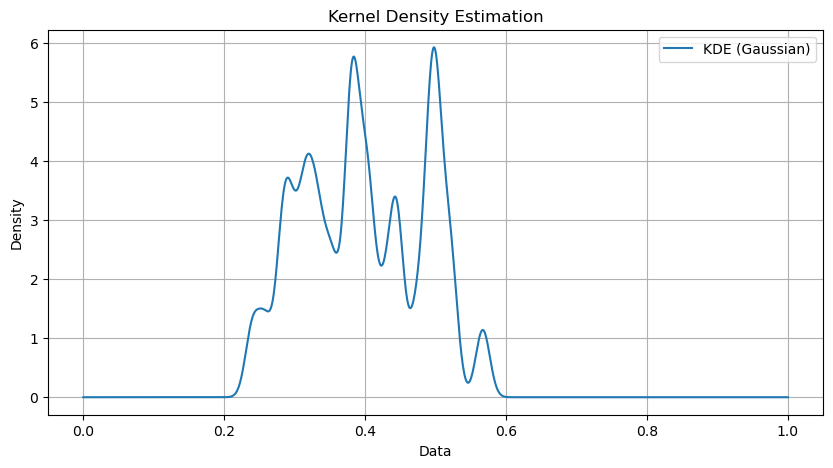

32 (36, 36)


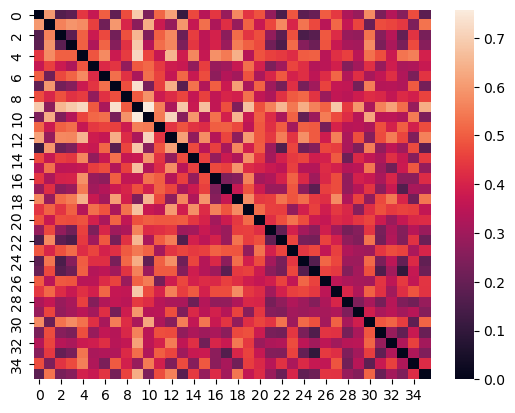

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


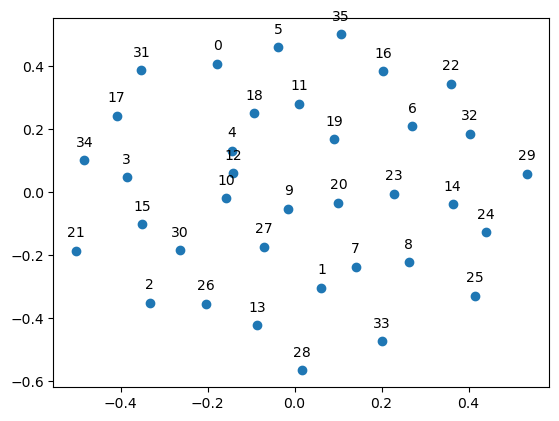

d 0 0 0.0 inf []
d 0 1 0.0 0.5461461825522178 [[4, 28]]
d 0 2 0.0 0.47085496905754776 [[5, 19]]
d 0 3 0.0 0.4668490951412514 [[20, 23]]
d 0 4 0.0 0.46234356581993663 [[4, 33]]
d 0 5 0.0 0.45713584287974995 [[9, 23]]
d 0 6 0.0 0.45318452911118745 [[4, 17]]
d 0 7 0.0 0.4507031450659068 [[10, 26]]
d 0 8 0.0 0.4456986582714788 [[9, 11]]
d 0 9 0.0 0.4440385248520614 [[4, 34]]
d 0 10 0.0 0.4432933702477818 [[9, 25]]
d 0 11 0.0 0.44120494563730583 [[9, 21]]
d 0 12 0.0 0.4404346497103907 [[9, 31]]
d 0 13 0.0 0.42646573684603417 [[4, 6]]
d 0 14 0.0 0.4160216503204768 [[4, 16]]
d 0 15 0.0 0.4135600850911446 [[8, 10]]
d 0 16 0.0 0.4069335525905011 [[9, 29]]
d 0 17 0.0 0.40683983000335433 [[10, 14]]
d 0 18 0.0 0.38469531883921426 [[9, 32]]
d 0 19 0.0 0.3779936125726361 [[10, 30]]
d 0 20 0.0 0.36500762197219294 [[1, 10]]
d 0 21 0.0 0.36385667870584026 [[9, 24]]
d 0 22 0.0 0.3636800571456269 [[9, 35]]
d 0 23 0.0 0.35073873996341975 [[10, 18]]
d 0 24 0.0 0.3477296127399967 [[9, 22]]
d 0 25 0.0 0.3456

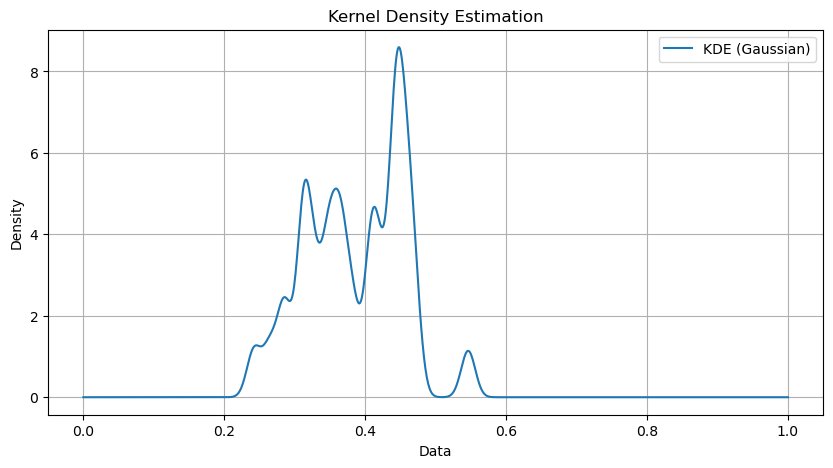

30 (36, 36)


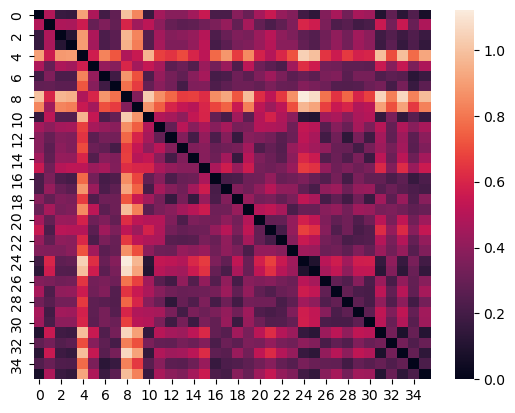

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


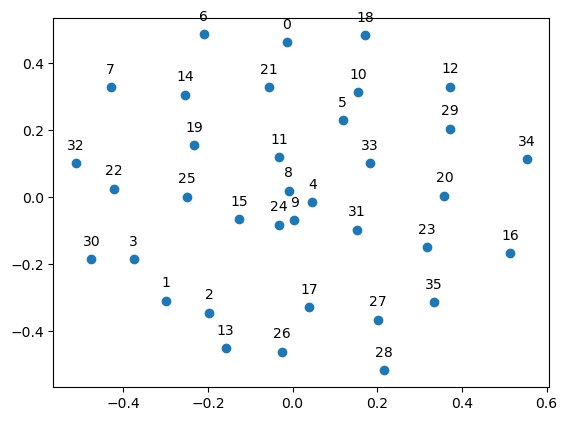

d 0 0 0.0 inf []
d 0 1 0.0 0.4023575978601349 [[8, 29]]
d 0 2 0.0 0.39600811297228855 [[1, 24]]
d 0 3 0.0 0.3757042298771176 [[8, 20]]
d 0 4 0.0 0.37082943311484995 [[5, 24]]
d 0 5 0.0 0.3586882056184595 [[8, 27]]
d 0 6 0.0 0.34333396972110275 [[8, 22]]
d 0 7 0.0 0.3352805925886062 [[15, 24]]
d 0 8 0.0 0.3273104015123348 [[8, 14]]
d 0 9 0.0 0.32554652113719307 [[8, 30]]
d 0 10 0.0 0.32344869997655035 [[21, 24]]
d 0 11 0.0 0.3027321290051086 [[4, 13]]
d 0 12 0.0 0.2732203934622468 [[8, 18]]
d 0 13 0.0 0.24077463006501476 [[8, 28]]
d 0 14 0.0 0.23630155342254422 [[8, 12]]
d 0 15 0.0 0.21219766994491163 [[7, 8]]
d 0 16 0.0 0.20788572765469093 [[8, 26]]
d 0 17 0.0 0.17856740889551614 [[8, 32]]
d 0 18 0.0 0.17398396542912642 [[8, 34]]
d 0 19 0.0 0.1438205753074725 [[8, 16]]
d 0 20 0.0 0.14008038216182328 [[8, 11]]
d 0 21 0.0 0.13456347840535132 [[8, 23]]
d 0 22 0.0 0.11941570438898175 [[6, 8]]
d 0 23 0.0 0.07815332725845214 [[8, 17]]
d 0 24 0.0 0.051413563517145655 [[3, 8]]
d 0 25 0.0 0.034

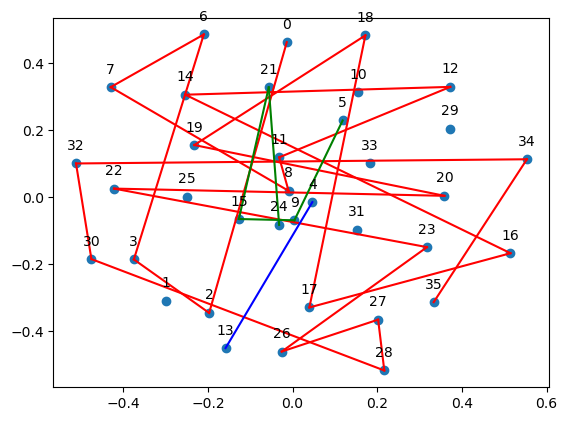

persistence =0.4023575978601349, finding: [1, 24]
 [[1, 5, 21, 24, 9, 15], [0, 2, 3, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 26, 27, 28, 30, 32, 34, 35], [4, 13]]
merging
[[1]]
[[1, 0]]
pbow:
[array([4., 1.]), array([10., 12.]), array([1., 0.])]
[[ 0.         12.52996409  3.16227766]
 [12.52996409  0.         15.        ]
 [ 3.16227766 15.          0.        ]]
score x0.5166666666666667: [0.0] [0.17391304347826086] [0.0] 
total score : 0.8888888888888888

[[1, 5, 21, 24, 9, 15], [0, 2, 3, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 26, 27, 28, 30, 32, 34, 35], [4, 13]]


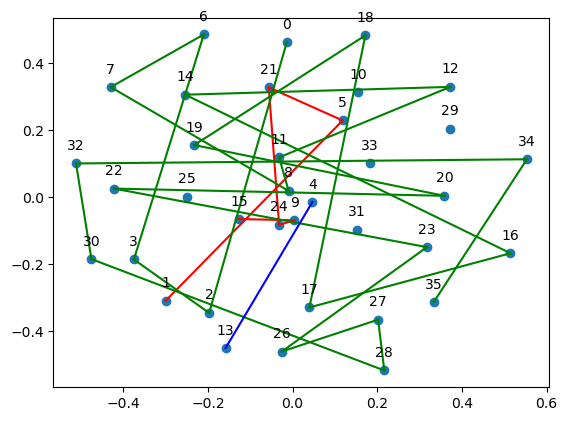

persistence =inf, finding: [8, 29]
 [[0, 2, 3, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 35], [1, 5, 21, 24, 9, 15], [4, 13]]
merging
[[29]]
[[1, 0]]
pbow:
[array([11., 12.]), array([4., 1.]), array([1., 0.])]
[[ 0.         13.03840481 15.62049935]
 [13.03840481  0.          3.16227766]
 [15.62049935  3.16227766  0.        ]]
score x0.5333333333333333: [0.16666666666666666] [0.0] [0.0] 
total score : 0.8888888888888888

[[0, 2, 3, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 35], [1, 5, 21, 24, 9, 15], [4, 13]]


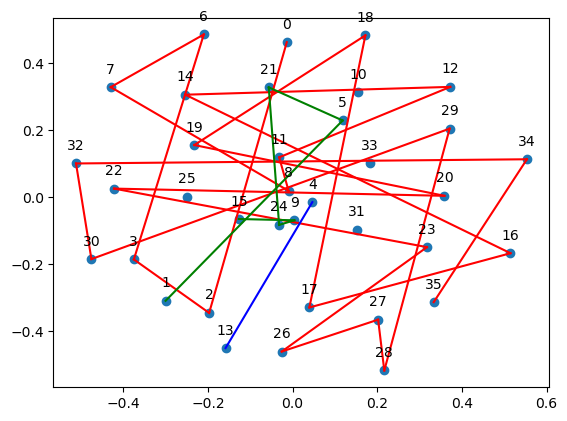

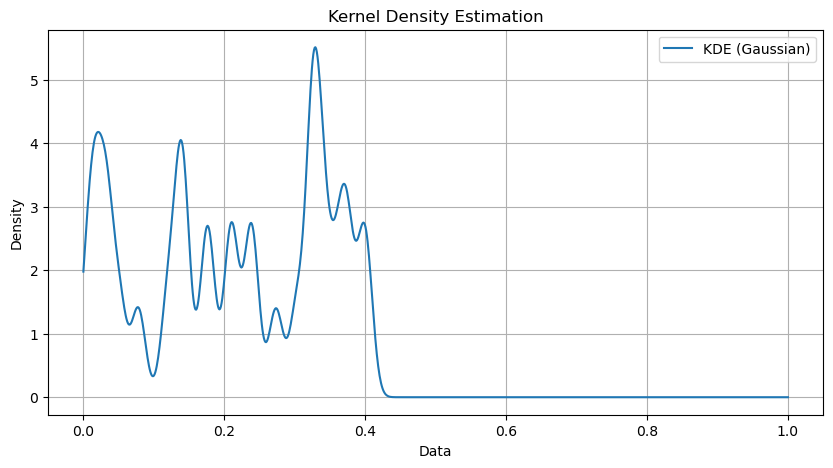

28 (36, 36)


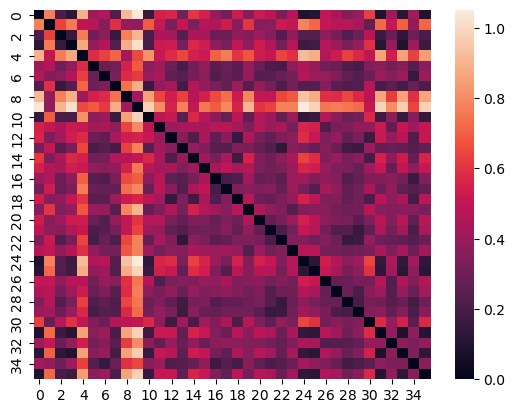

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


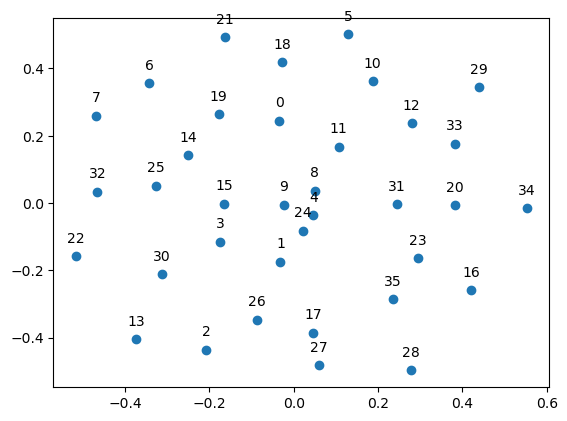

d 0 0 0.0 inf []
d 0 1 0.0 0.4188593539777018 [[12, 24]]
d 0 2 0.0 0.3938037489887646 [[4, 18]]
d 0 3 0.0 0.3930355253931054 [[9, 20]]
d 0 4 0.0 0.36683777663520045 [[4, 6]]
d 0 5 0.0 0.36204053673386827 [[14, 24]]
d 0 6 0.0 0.3593014822114807 [[9, 21]]
d 0 7 0.0 0.3589309373087226 [[9, 34]]
d 0 8 0.0 0.3549252195966265 [[24, 30]]
d 0 9 0.0 0.3113485936263375 [[5, 9]]
d 0 10 0.0 0.29826573179441285 [[4, 16]]
d 0 11 0.0 0.27569653604768896 [[9, 29]]
d 0 12 0.0 0.2503138319899848 [[9, 28]]
d 0 13 0.0 0.24806092119732537 [[9, 26]]
d 0 14 0.0 0.24547596087661783 [[9, 15]]
d 0 15 0.0 0.2338936089065229 [[9, 27]]
d 0 16 0.0 0.22666458642064813 [[9, 13]]
d 0 17 0.0 0.22619973509493685 [[9, 23]]
d 0 18 0.0 0.22345046255453271 [[9, 22]]
d 0 19 0.0 0.22295066495762816 [[1, 24]]
d 0 20 0.0 0.21098590445894072 [[9, 17]]
d 0 21 0.0 0.20045446628209818 [[9, 11]]
d 0 22 0.0 0.19767084308764482 [[9, 32]]
d 0 23 0.0 0.11458352039090802 [[7, 9]]
d 0 24 0.0 0.09746690544858161 [[2, 9]]
d 0 25 0.0 0.09571

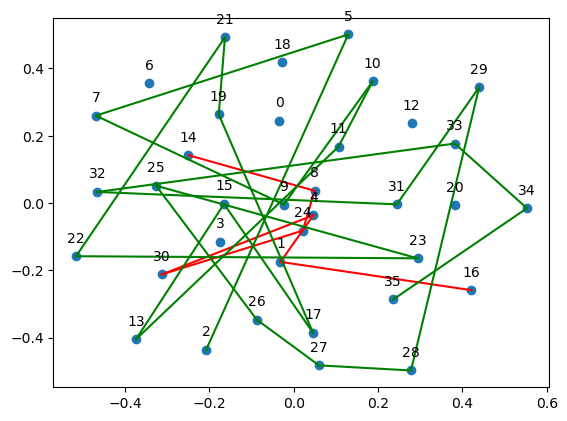

persistence =0.3930355253931054, finding: [4, 6]
 [[16, 1, 4, 6, 30, 24, 8, 14], [2, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]
merging
[[6]]
[[0, 0]]
pbow:
[array([1., 2., 3., 1., 0.]), array([10.,  3.,  2.,  2.,  5.])]
[[ 0.         10.44030651]
 [10.44030651  0.        ]]
score x0.5166666666666667: [0.125] [0.21739130434782608] 
total score : 0.8333333333333334

[[16, 1, 4, 6, 30, 24, 8, 14], [2, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]


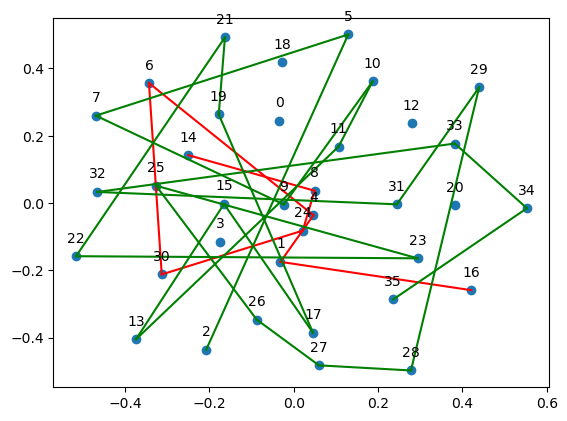

persistence =0.3938037489887646, finding: [9, 20]
 [[2, 5, 7, 9, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35], [16, 1, 4, 6, 30, 24, 8, 14]]
merging
[[20]]
[[1, 0]]
pbow:
[array([ 3.,  3., 10.,  5.,  2.]), array([2., 3., 1., 0., 1.])]
[[ 0.         10.39230485]
 [10.39230485  0.        ]]
score x0.5333333333333333: [0.20833333333333334] [0.125] 
total score : 0.8333333333333334

[[2, 5, 7, 9, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35], [16, 1, 4, 6, 30, 24, 8, 14]]


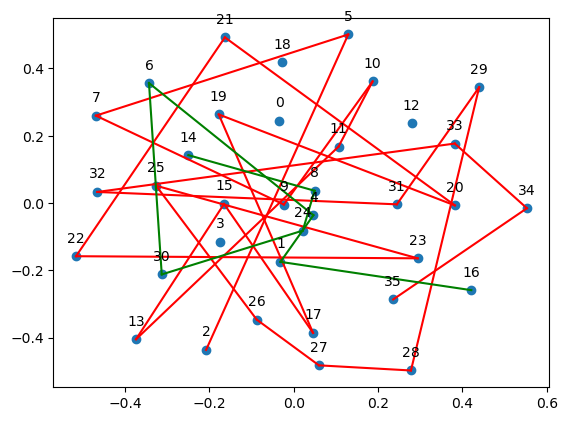

persistence =0.4188593539777018, finding: [4, 18]
 [[1, 4, 6, 8, 14, 16, 18, 24, 30], [2, 5, 7, 9, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]
merging
[[18]]
[[1, 0]]
pbow:
[array([0., 1., 1., 2., 4.]), array([ 5.,  2., 10.,  3.,  3.])]
[[ 0.         10.44030651]
 [10.44030651  0.        ]]
score x0.55: [0.1111111111111111] [0.20833333333333334] 
total score : 0.8333333333333334

[[1, 4, 6, 8, 14, 16, 18, 24, 30], [2, 5, 7, 9, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]


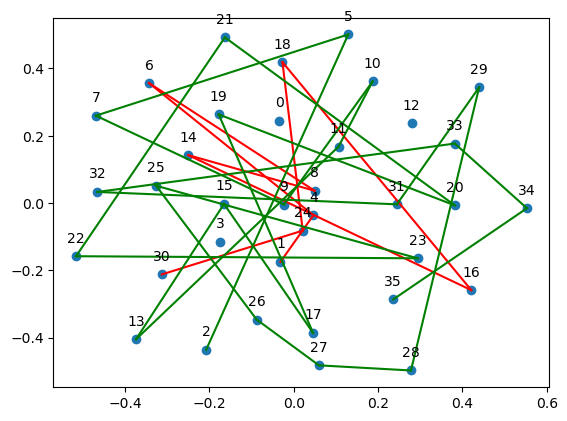

persistence =inf, finding: [12, 24]
 [[1, 4, 6, 8, 12, 14, 16, 18, 24, 30], [2, 5, 7, 9, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]
merging
[[12]]
[[0, 0]]
pbow:
[array([1., 0., 5., 2., 1.]), array([10.,  5.,  3.,  3.,  2.])]
[[ 0.         10.58300524]
 [10.58300524  0.        ]]
score x0.5666666666666667: [0.1] [0.20833333333333334] 
total score : 0.8333333333333334

[[1, 4, 6, 8, 12, 14, 16, 18, 24, 30], [2, 5, 7, 9, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]


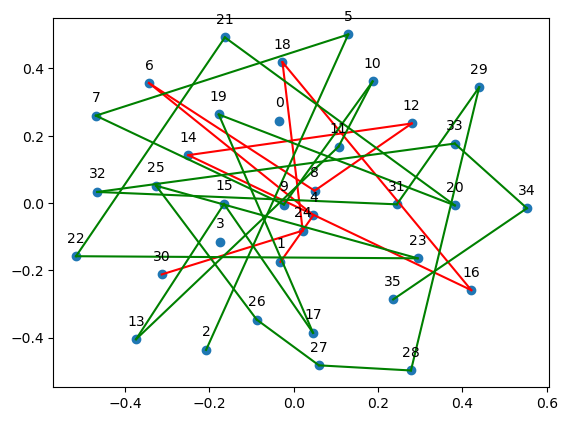

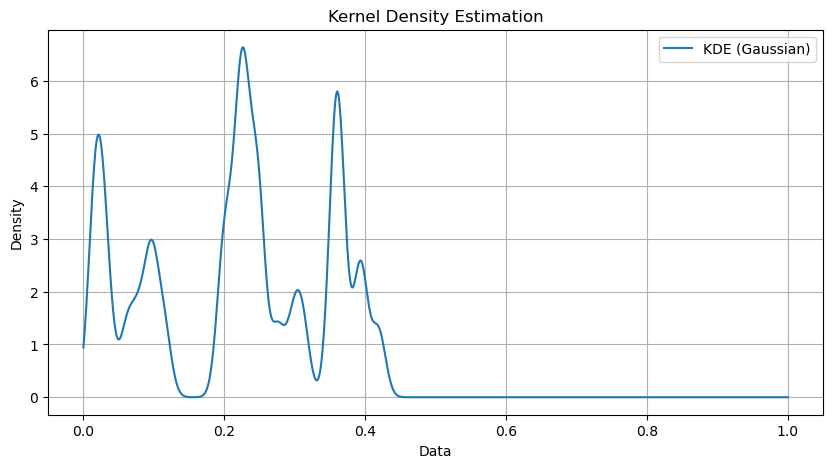

26 (36, 36)


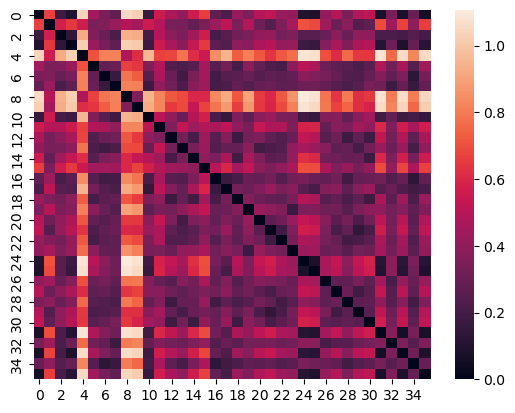

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


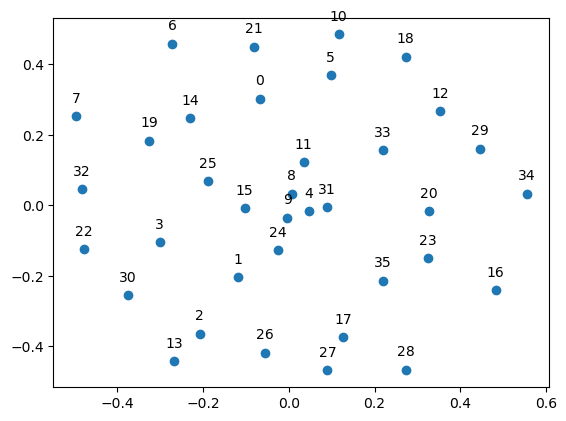

d 0 0 0.0 inf []
d 0 1 0.0 0.37543493785691895 [[14, 24]]
d 0 2 0.0 0.36637606644225307 [[4, 21]]
d 0 3 0.0 0.3527537116593292 [[8, 30]]
d 0 4 0.0 0.35233664093782757 [[4, 29]]
d 0 5 0.0 0.32633282480051684 [[9, 27]]
d 0 6 0.0 0.30308222351074066 [[15, 24]]
d 0 7 0.0 0.29423554497865334 [[4, 5]]
d 0 8 0.0 0.29263780966877306 [[1, 24]]
d 0 9 0.0 0.2851390958029931 [[4, 20]]
d 0 10 0.0 0.2799738539875991 [[8, 22]]
d 0 11 0.0 0.27971415117428733 [[8, 12]]
d 0 12 0.0 0.26508262855731535 [[4, 18]]
d 0 13 0.0 0.21919940271755012 [[4, 13]]
d 0 14 0.0 0.2082440827849389 [[9, 26]]
d 0 15 0.0 0.20317181859632427 [[8, 28]]
d 0 16 0.0 0.18462785132062198 [[4, 6]]
d 0 17 0.0 0.18288806420295223 [[7, 8]]
d 0 18 0.0 0.1756704325647156 [[9, 32]]
d 0 19 0.0 0.17230309624248696 [[4, 34]]
d 0 20 0.0 0.17080450004772296 [[9, 11]]
d 0 21 0.0 0.1534879094697592 [[4, 16]]
d 0 22 0.0 0.14153878519242402 [[8, 23]]
d 0 23 0.0 0.0968583763544486 [[8, 19]]
d 0 24 0.0 0.05964481399747179 [[2, 8]]
d 0 25 0.0 0.0559

IndexError: list index out of range

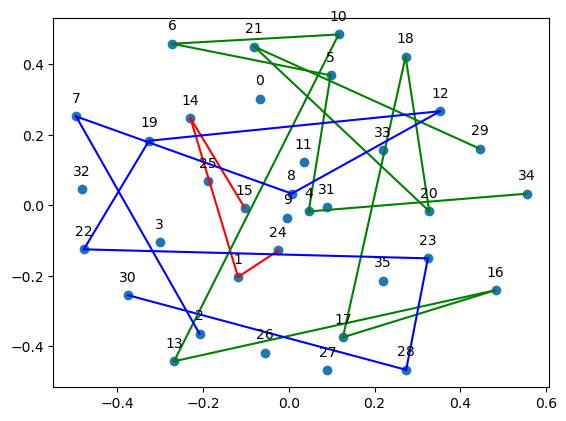

In [18]:
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()

    
    count = 0
    results = []
    dv_seq = []

    for (birth_value, death_value), d in [(i[1], i[0]) for i in persistence if i[0] == 0]:
        tolerance = 1e-6
        birth_simplices = []
        death_simplices = []
        filtration = simplex_tree.get_filtration()

        for simplex, filtration_value in filtration:
            # print(filtration_value, birth_value)
            if abs(filtration_value - birth_value) < tolerance:
                # print(simplex)
                birth_simplices.append(simplex)
            elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf and d != 0):
                death_simplices.append(simplex)
                
        involved_points_d = (mergeSublistsWithSharedItems(death_simplices))

        if len(involved_points_d) >= 0 : 
            print('d', d, count, birth_value, death_value, involved_points_d) 
            results.append([death_value, involved_points_d])
            dv_seq.append(death_value)
        count += 1
    print("the gaps:")
    print(findLargestGaps(dv_seq, 3))
    
    a = []
    for [death_value, concern_points] in results:
        for c in concern_points:
            # print(c)
            a.append(c)
            
    print(a)
    last_merged = None
    last_distance = None
    score = 0
    has_draw = False
    for i in range(min(len(a)-1, len(results)-1), -1, -1):
        warn_flag = False
        f = flatten(a[i:len(a)])
        if (np.unique(f).shape[0] == total_nums):
            continue
        merged = mergeSublistsWithSharedItems(a[i:len(a)])
        print(f"persistence ={results[i][0]}, finding: {a[i]}\n", merged)
        # print(merged, last_merged)
        score = getTotalLength(merged)/normal_nums/2

        newly_merged = []
        newly_added = []
        merging = []

        if (last_merged != None and len(last_merged)):
            print("merging")
            for idxa, list_a in enumerate(last_merged):
                for idxb, list_b in enumerate(merged):
                    # print(list_a, list_b)
                    if (isProperSuperset(list_a, list_b)):
                        newly_merged.append([idxa, idxb])
                        newly_added.append(findDifferentElements(list_a, list_b))
        
            print(newly_added)
            print(newly_merged)

            if (len(newly_merged) >= 2):
                merging = list(set(newly_merged[0] + newly_merged[1]))
                # merging = find_different_elements(newly_merged[0], newly_merged[1])
                print(merging)
                # print(last_distance)
                if(len(merging) and last_distance.shape[0] > max(merging[-1], merging[-2])):
                    print("merging with pbow_d: ",last_distance[merging[-1]][merging[-2]], np.max(last_distance))
                    if (last_distance[merging[-1]][merging[-2]] >= np.max(last_distance)/2 and score > 0.6 ):
                        print("warn")
                        warn_flag = True
                        a[i] = [0, 0]
                        merged = copy.deepcopy(last_merged)

        
        last_merged = copy.deepcopy(merged)


        
        sub_pers = []
        min_length = float('Inf')
        for sub_points in merged:
            if (len(sub_points) <= 1):
                continue
            min_length = min(min_length, len(sub_points))
            sub_diagram = gd.RipsComplex(distance_matrix=np.array(data)[sub_points][:,sub_points], max_edge_length=100)
            sub_simplex_tree = sub_diagram.create_simplex_tree(max_dimension=2)
            sub_persistence = sub_simplex_tree.persistence()
            sub_pd = np.array([[b, d] for dim, (b, d) in sub_persistence if (dim == 0) and (d != float('inf'))])
            sub_pers.append(sub_pd)

        if (len(sub_pers) > 1 and min_length > 1):
            pbow = perscode.PBoW(N = min(5, min_length), normalize = False)
            pbow_diagrams  = pbow.transform(sub_pers)
            print("pbow:")
            print(pbow_diagrams)
            pbow_distance = np.zeros((len(pbow_diagrams),len(pbow_diagrams)))
            for k in range(len(pbow_diagrams)):
                for j in range(len(pbow_diagrams)):
                    pbow_distance[k][j] = np.linalg.norm(pbow_diagrams[k] - pbow_diagrams[j])
            print(pbow_distance)
        
            if (not warn_flag):
                last_distance = copy.deepcopy(pbow_distance)

        print(f"score x{score}: ",end='')
        total_errors = 0
        for j in merged:
            print([np.mean(np.array(j) >= normal_nums)], end=' ')
            total_errors += min(np.sum((np.array(j) >= normal_nums) == 0),np.sum((np.array(j) >= normal_nums) == 1))
        print(f"\ntotal score : {1- total_errors/data.shape[0]}")
        print()

        if (score >= 0.5 and len(merged) > 1):
            plt.clf()
            plt.scatter(mds_results[:, 0], mds_results[:, 1])
            for idx, points in enumerate(mds_results):
                plt.annotate(idx, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')

            # print(merged)
            draw_point_set = copy.deepcopy(merged)
            colors = ['r', 'g', 'b']
            for color, layer in enumerate(merged):
                # print(layer)
                for p in range(len(layer)-1):
                    p1 = mds_results[layer[p]]
                    p2 = mds_results[layer[p + 1]]
                    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], colors[color]+'-')
            has_draw = True
            print(draw_point_set)
            plt.show()

    if (has_draw):
        pass

    group = np.zeros((total_nums,total_nums))
    for i in mergeSublistsWithSharedItems(a)[0]:
        group[i][i] = 1

    
    X = np.array([x for x in dv_seq if x != float('Inf')])
    X = X.reshape(-1, 1)

    # 初始化KDE模型
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

    # 进行密度估计
    X_sample = np.linspace(0, 1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(X_sample)

    plt.figure(figsize=(10, 5))
    plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.scatter(mds_results[:, 0], mds_results[:, 1])
    # for i, points in enumerate(mds_results):
    #     plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    # plt.show()
